In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## location of the files
data_dir = '/content/drive/MyDrive/ECG/'

### Test on ECG Data

The dataset you will use is based on one from [timeseriesclassification.com](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000).

Try to design and train your MLP to classify normal and abnormal ECG samples.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, RNN
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers.merge import concatenate
from keras.utils import plot_model
from keras import regularizers
from keras import layers, Model
from keras import backend as K
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import accuracy_score, auc, roc_curve, RocCurveDisplay

# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

# Read in the additional datasets
dataframe = pd.read_csv(data_dir + 'mitbih_test.csv', header=None)
raw_data2 = dataframe.values
dataframe = pd.read_csv(data_dir + 'mitbih_train.csv', header=None)
raw_data2 = np.vstack((raw_data2,dataframe.values))

dataframe = pd.read_csv(data_dir + 'ptbdb_normal.csv', header=None)
raw_data3 = dataframe.values
dataframe = pd.read_csv(data_dir + 'ptbdb_abnormal.csv', header=None)
raw_data3 = np.vstack((raw_data3,dataframe.values))


## For the original dataset

Class proportion: 0.5840336134453782


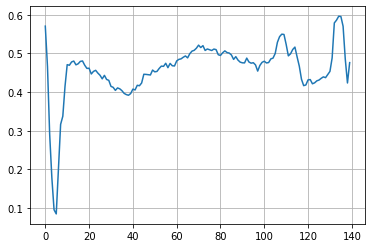

In [ ]:
# The last element contains the labels
labels = raw_data[:, -1]

print('Class proportion:', np.sum(labels)/labels.shape[0])

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=21)

# Normalize to [0, 1]
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

# plot data
plt.grid()
plt.plot(np.arange(train_data.shape[1]), train_data[0])
plt.show()

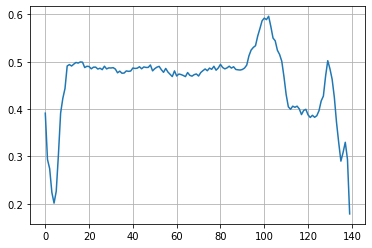

In [ ]:
plt.grid()
plt.plot(np.arange(140), train_data[100])
plt.show()

### CNN model

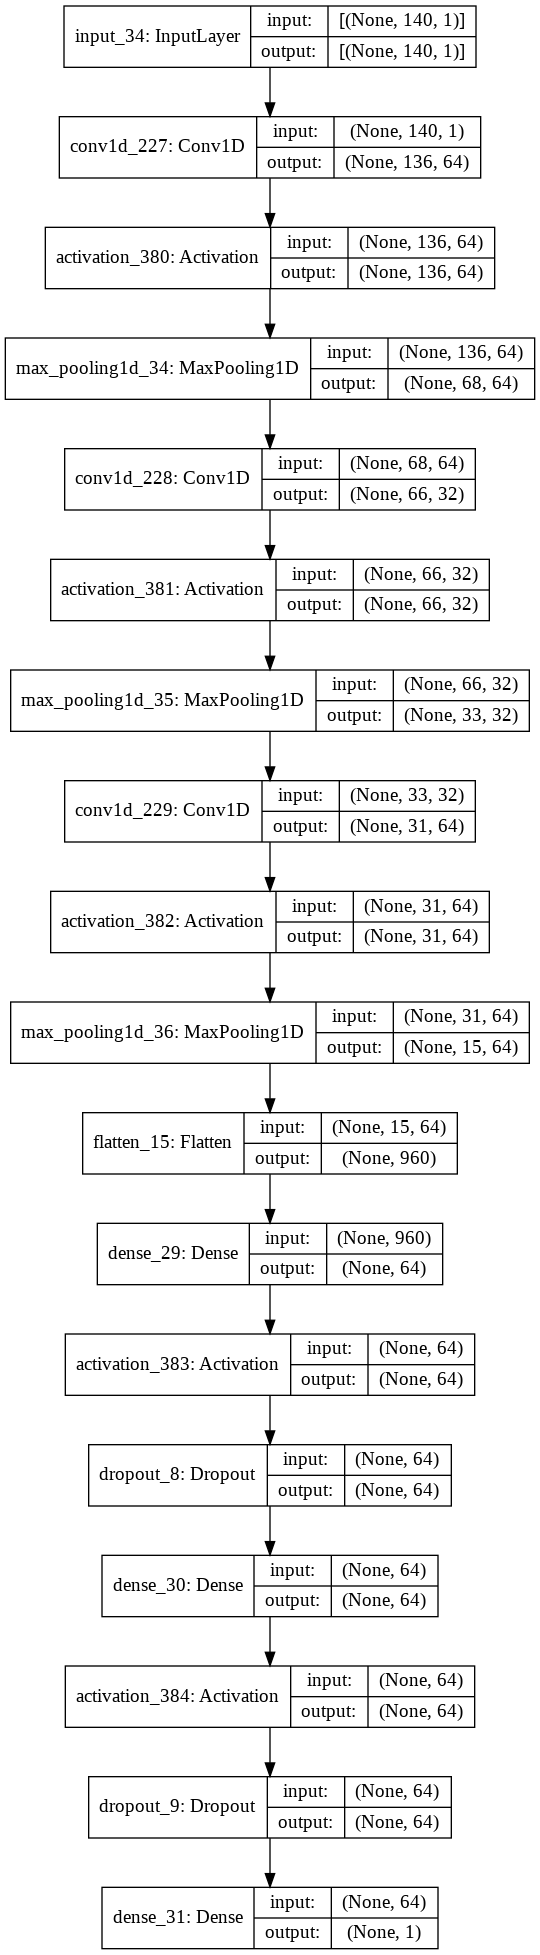

In [ ]:
input = layers.Input(shape=(train_data.shape[1],1)) # input with training data shape

# convulutional layers with max pooling
x = layers.Conv1D(64,5)(input)
x = layers.Activation('relu')(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.Conv1D(32,3)(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.Conv1D(64,3)(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.Flatten()(x)

# dense and dropout layers
x = layers.Dense(64)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)

# final output layer
x = layers.Dense(1,activation='sigmoid')(x)

CNN_model = Model(inputs=input, outputs=x)

plot_model(CNN_model, show_shapes=True, to_file='CNN_module.png')

In [ ]:
CNN_model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
# Fit the model
checkpoint = ModelCheckpoint("best_model.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = CNN_model.fit(x=train_data,y=train_labels, epochs=9,validation_split=0.2,callbacks=[checkpoint])

Epoch 1/9
100/100 [==============================] - 3s 18ms/step - loss: 0.6819 - accuracy: 0.5651 - val_loss: 0.6417 - val_accuracy: 0.5950

Epoch 00001: val_accuracy improved from -inf to 0.59500, saving model to best_model.hdf5
Epoch 2/9
100/100 [==============================] - 2s 15ms/step - loss: 0.5005 - accuracy: 0.7393 - val_loss: 0.0911 - val_accuracy: 0.9800

Epoch 00002: val_accuracy improved from 0.59500 to 0.98000, saving model to best_model.hdf5
Epoch 3/9
100/100 [==============================] - 2s 16ms/step - loss: 0.1170 - accuracy: 0.9723 - val_loss: 0.0929 - val_accuracy: 0.9737

Epoch 00003: val_accuracy did not improve from 0.98000
Epoch 4/9
100/100 [==============================] - 2s 15ms/step - loss: 0.1153 - accuracy: 0.9730 - val_loss: 0.0877 - val_accuracy: 0.9800

Epoch 00004: val_accuracy did not improve from 0.98000
Epoch 5/9
100/100 [==============================] - 2s 16ms/step - loss: 0.0625 - accuracy: 0.9806 - val_loss: 0.0721 - val_accuracy: 0.

### Reprocess the data for the next models

In [ ]:
train_data, test_data2, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=21)

n_steps = 4

train_data = train_data.reshape((train_data.shape[0], n_steps, data.shape[1]//n_steps))
test_data2 = test_data2.reshape((test_data2.shape[0], n_steps, data.shape[1]//n_steps))

# Normalize to [0, 1]
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data2 = (test_data2 - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data2 = tf.cast(test_data2, tf.float32)

### CNN-LSTM Model

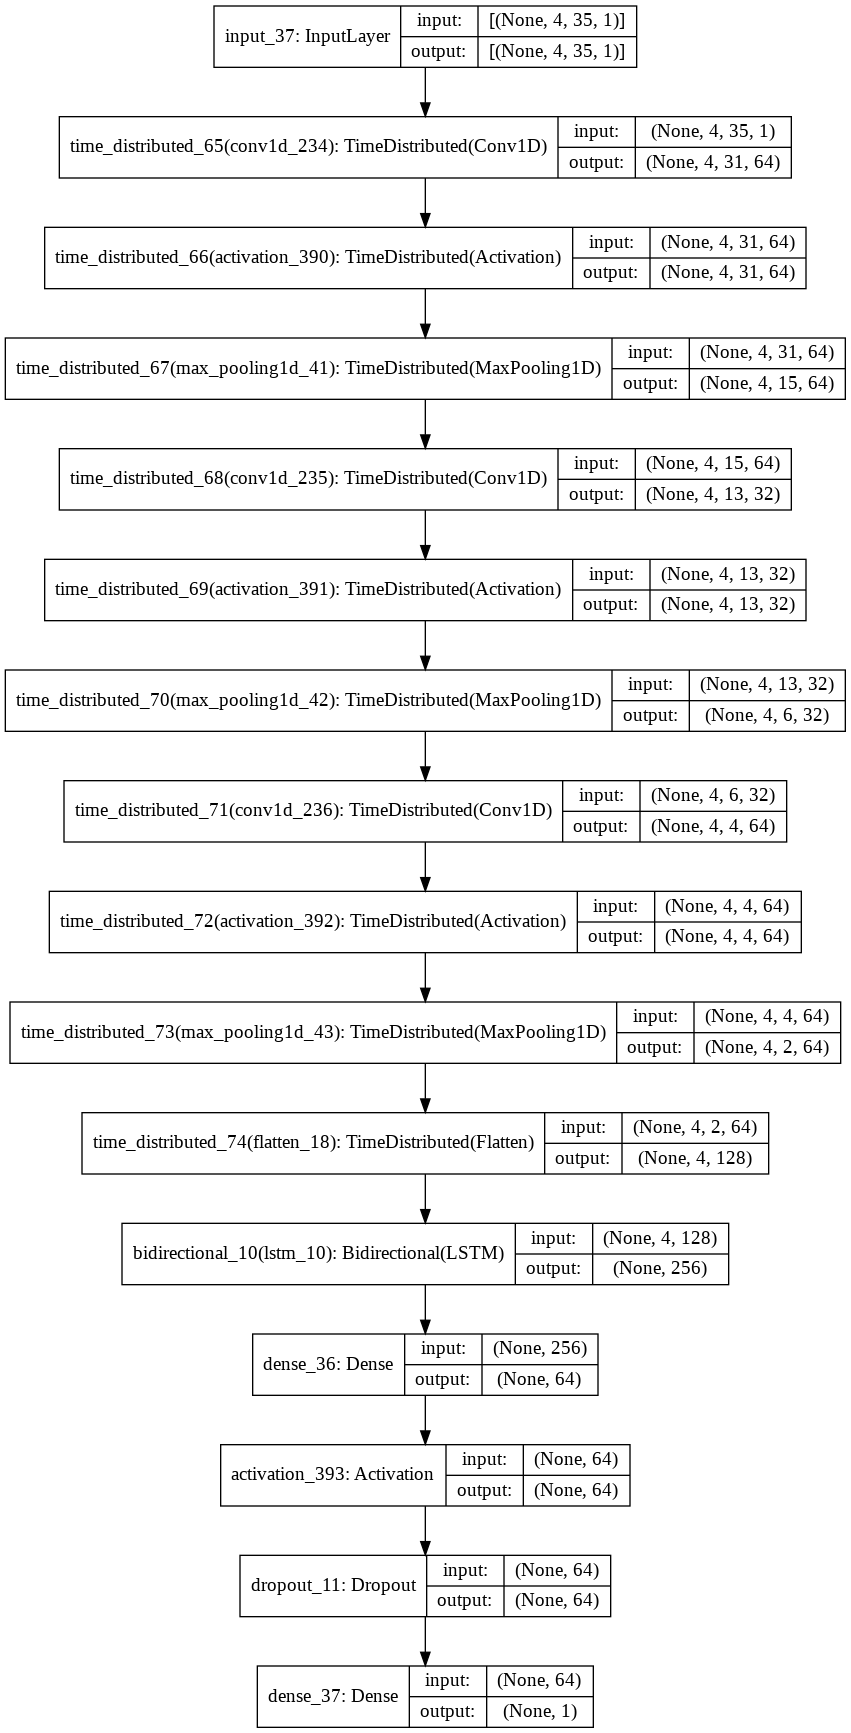

In [ ]:
input = layers.Input(shape=(train_data.shape[1],train_data.shape[2],1)) # input layer with training data shape

# dense and dropout layer
x = layers.TimeDistributed(Conv1D(64,5))(input)
x = layers.TimeDistributed(Activation('relu'))(x)
x = layers.TimeDistributed(MaxPooling1D(pool_size=2))(x)
x = layers.TimeDistributed(Conv1D(32,3))(x)
x = layers.TimeDistributed(Activation('relu'))(x)
x = layers.TimeDistributed(MaxPooling1D(pool_size=2))(x)
x = layers.TimeDistributed(Conv1D(64,3))(x)
x = layers.TimeDistributed(Activation('relu'))(x)
x = layers.TimeDistributed(MaxPooling1D(pool_size=2))(x)
x = layers.TimeDistributed(Flatten())(x)
# bidirection lstm layer
x = layers.Bidirectional(layers.LSTM(128,dropout=0.3,recurrent_dropout=0.3))(x)

# dense and dropout layers
x = layers.Dense(64)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)

# decision layer
x = layers.Dense(1,activation='sigmoid')(x)

LSTM_model = Model(inputs=input, outputs=x)

plot_model(LSTM_model, show_shapes=True, to_file='CNNLSTM_module.png')

In [ ]:
LSTM_model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
# Fit the model
checkpoint = ModelCheckpoint("best_model.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = LSTM_model.fit(x=train_data,y=train_labels, epochs=5,validation_split=0.2,callbacks=[checkpoint])

Epoch 1/5
100/100 [==============================] - 11s 47ms/step - loss: 0.6819 - accuracy: 0.5730 - val_loss: 0.6099 - val_accuracy: 0.9787

Epoch 00001: val_accuracy improved from -inf to 0.97875, saving model to best_model.hdf5
Epoch 2/5
100/100 [==============================] - 4s 39ms/step - loss: 0.3068 - accuracy: 0.8877 - val_loss: 0.0748 - val_accuracy: 0.9800

Epoch 00002: val_accuracy improved from 0.97875 to 0.98000, saving model to best_model.hdf5
Epoch 3/5
100/100 [==============================] - 4s 40ms/step - loss: 0.1207 - accuracy: 0.9688 - val_loss: 0.0705 - val_accuracy: 0.9812

Epoch 00003: val_accuracy improved from 0.98000 to 0.98125, saving model to best_model.hdf5
Epoch 4/5
100/100 [==============================] - 4s 39ms/step - loss: 0.0934 - accuracy: 0.9730 - val_loss: 0.0551 - val_accuracy: 0.9850

Epoch 00004: val_accuracy improved from 0.98125 to 0.98500, saving model to best_model.hdf5
Epoch 5/5
100/100 [==============================] - 4s 39ms/s

### Inception Model

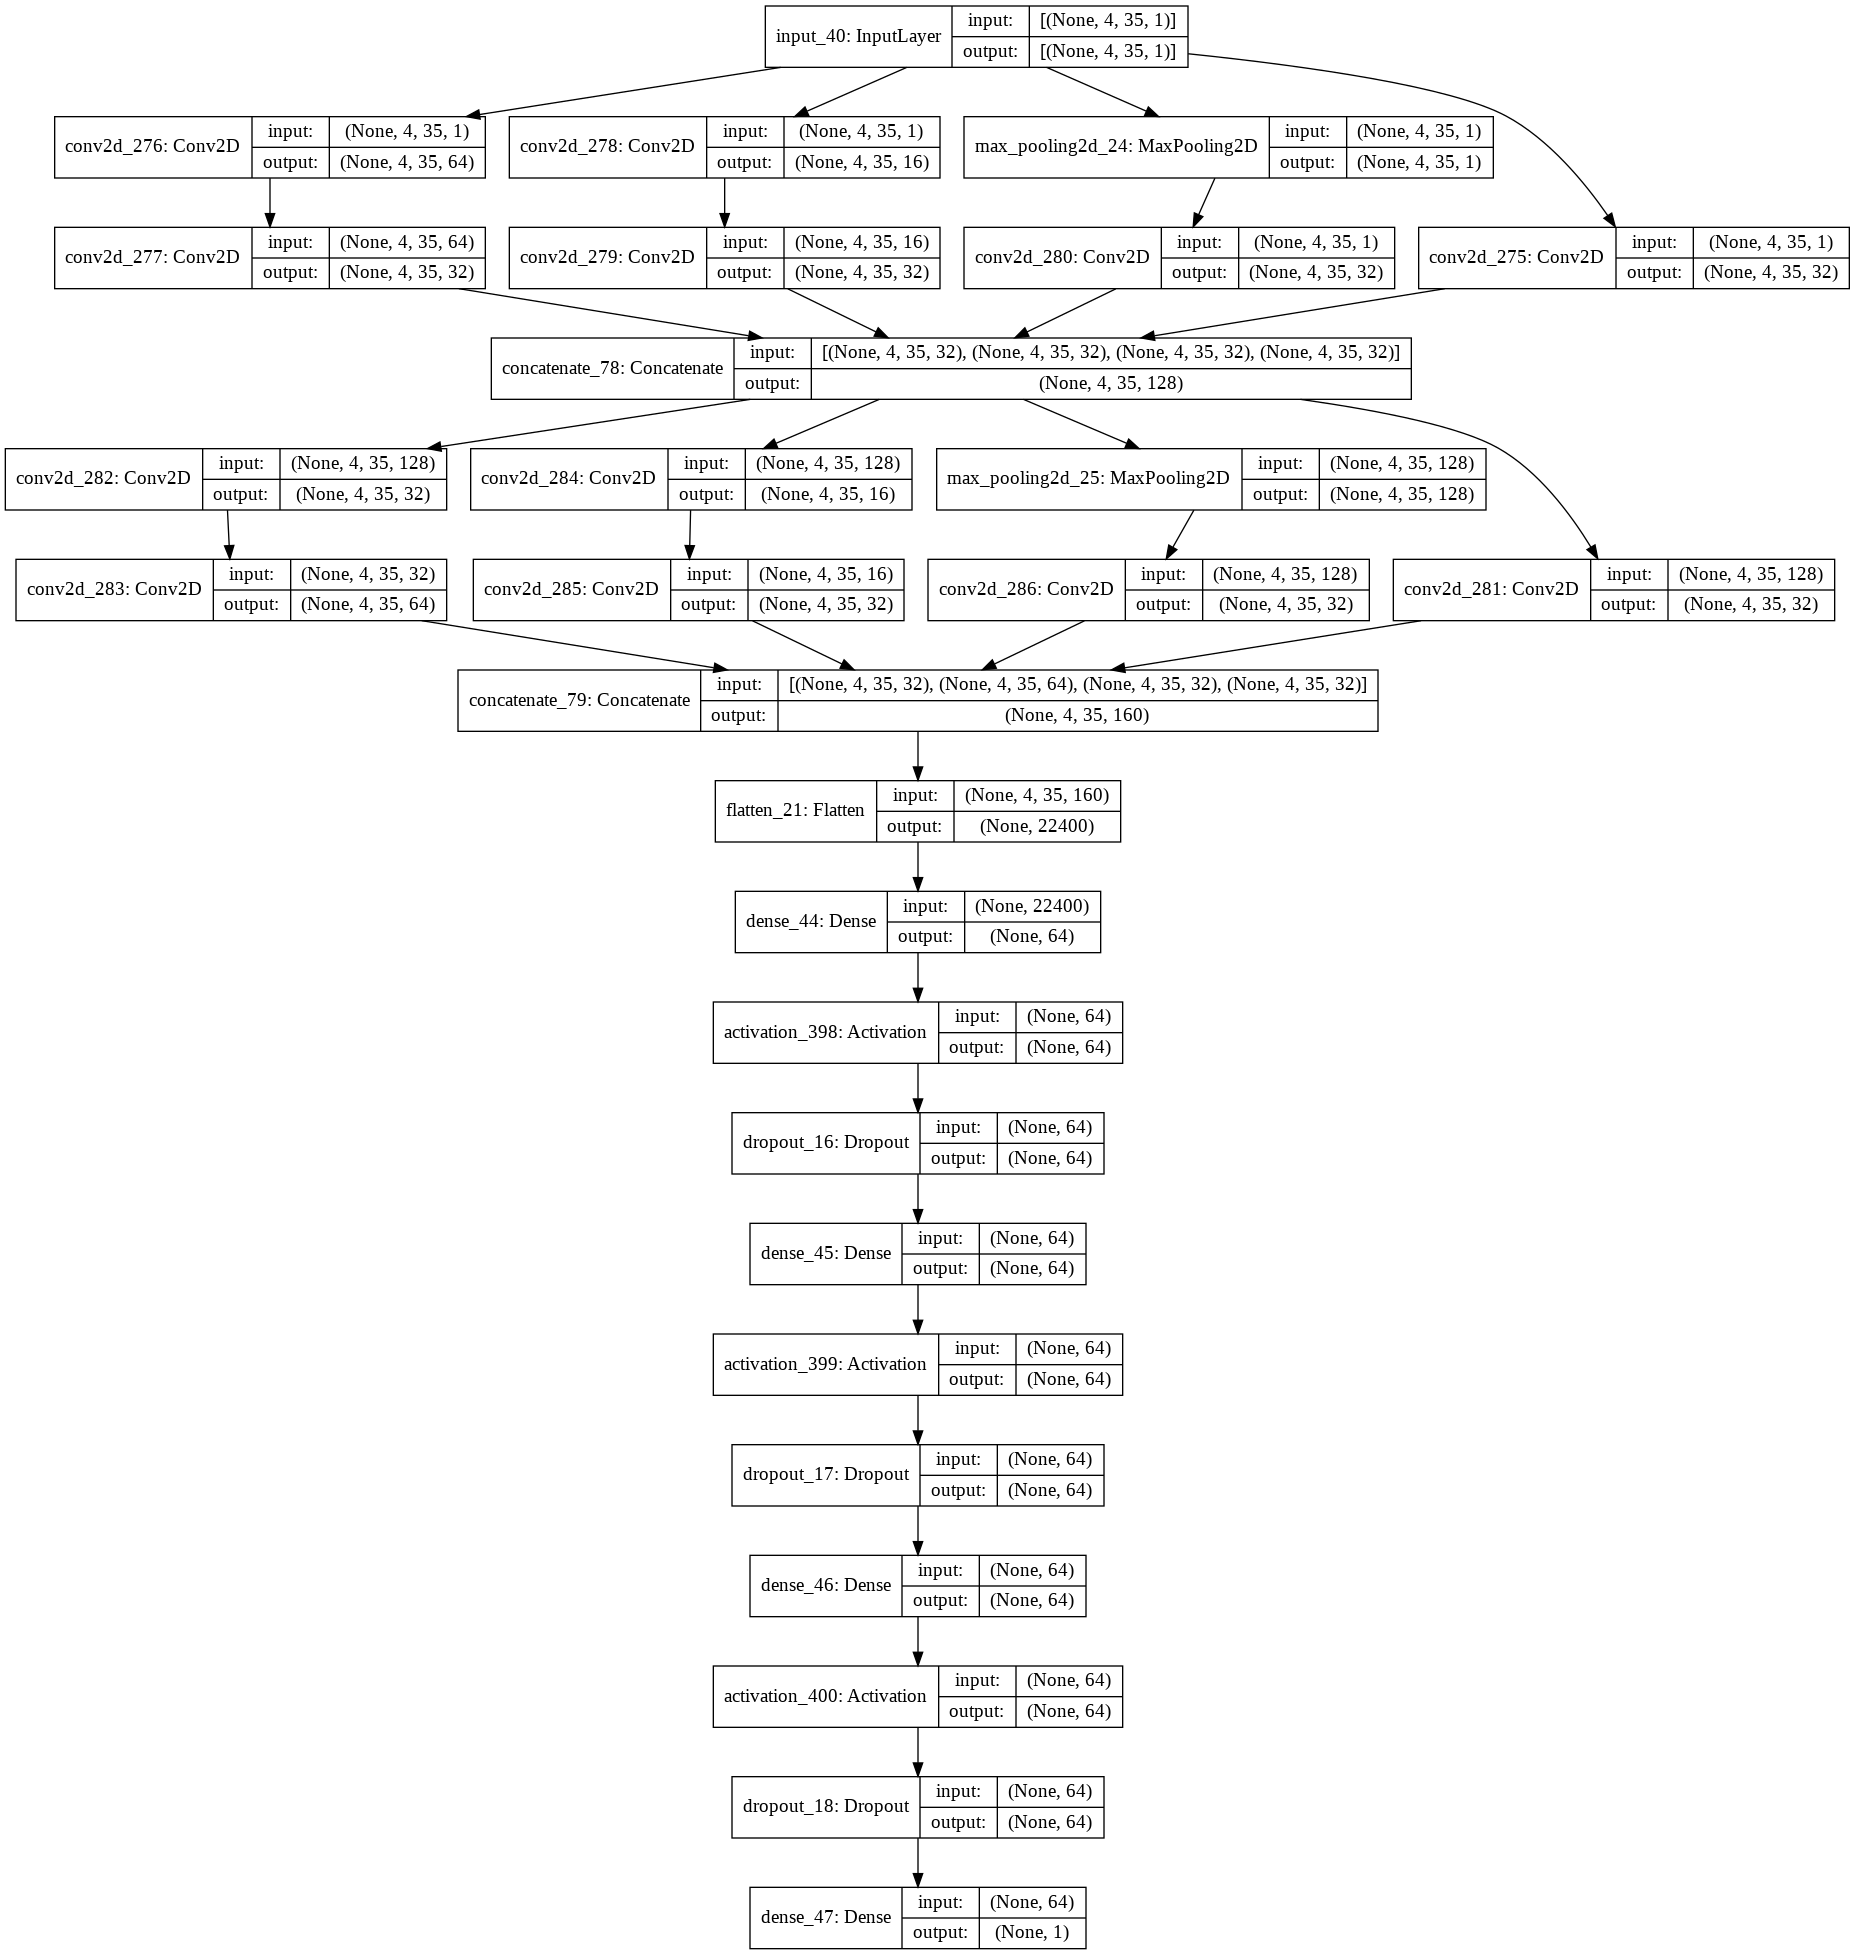

In [ ]:
# function for creating a projected inception module
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
	# 1x1 conv
	conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
	# 3x3 conv
	conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
	conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
	# 5x5 conv
	conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
	conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
	# 3x3 max pooling
	pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
	pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
	# concatenate filters, assumes filters/channels last
	layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
	return layer_out
 
# define model input
input = layers.Input(shape=(train_data.shape[1], train_data.shape[2],1))
# add inception block 1
x = inception_module(input, 32, 64, 32, 16, 32, 32)
# add inception block 1
x = inception_module(x, 32, 32, 64, 16, 32, 32)
# create model
x = layers.Flatten()(x)
# dense and dropout layers
x = layers.Dense(64)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)

## prediction layer
x = layers.Dense(1,activation='sigmoid')(x)

inception_model = Model(inputs=input, outputs=x)

# plot model architecture
plot_model(inception_model, show_shapes=True, to_file='inception_module.png')

In [ ]:
inception_model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
# Fit the model
checkpoint = ModelCheckpoint("best_model.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = inception_model.fit(x=train_data,y=train_labels, epochs=3,validation_split=0.2,callbacks=[checkpoint])

Epoch 1/5
100/100 [==============================] - 15s 127ms/step - loss: 0.6660 - accuracy: 0.5677 - val_loss: 0.1051 - val_accuracy: 0.9538

Epoch 00001: val_accuracy improved from -inf to 0.95375, saving model to best_model.hdf5
Epoch 2/5
100/100 [==============================] - 12s 124ms/step - loss: 0.1450 - accuracy: 0.9572 - val_loss: 0.0410 - val_accuracy: 0.9900

Epoch 00002: val_accuracy improved from 0.95375 to 0.99000, saving model to best_model.hdf5
Epoch 3/5
100/100 [==============================] - 12s 124ms/step - loss: 0.0706 - accuracy: 0.9800 - val_loss: 0.0387 - val_accuracy: 0.9937

Epoch 00003: val_accuracy improved from 0.99000 to 0.99375, saving model to best_model.hdf5
Epoch 4/5
 41/100 [===========>..................] - ETA: 6s - loss: 0.1117 - accuracy: 0.9780

KeyboardInterrupt: ignored

### Evaluation

For CNN model:
Accuracy: 0.991
AUC-ROC: 0.997950487012987


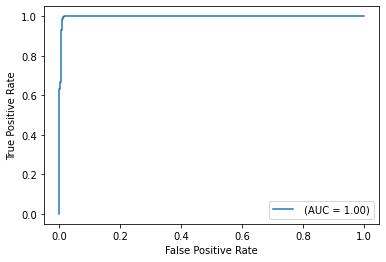

For CNN-LSTM model:
Accuracy: 0.989
AUC-ROC: 0.998429383116883


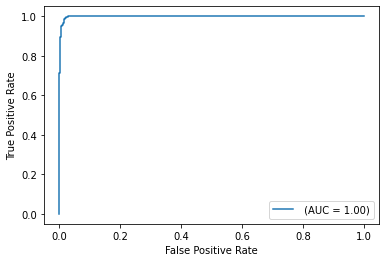

For Inception model:
Accuracy: 0.989
AUC-ROC: 0.9986444805194805


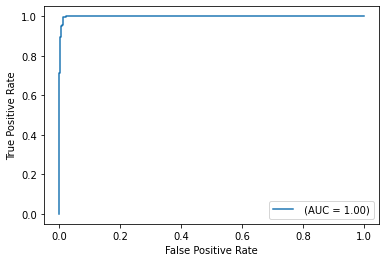

In [ ]:
models = [CNN_model,LSTM_model,inception_model]
modelnames = ['CNN','CNN-LSTM','Inception']

for i, model in enumerate(models):
  print('For', modelnames[i], 'model:')
  ## predict
  if i == 0:
    prediction = model.predict(test_data)
  else:
    prediction = model.predict(test_data2)
  fpr, tpr, _ = roc_curve(test_labels, prediction)
  aucroc = auc(fpr, tpr)
  accuracy = accuracy_score(test_labels,np.round_(prediction))
  print('Accuracy:', accuracy)
  print('AUC-ROC:', aucroc)
  roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr,roc_auc=aucroc,estimator_name = '')
  roc_display.plot()
  plt.show()


## For mitbih dataset

Class proportion: 0.17229501306580414


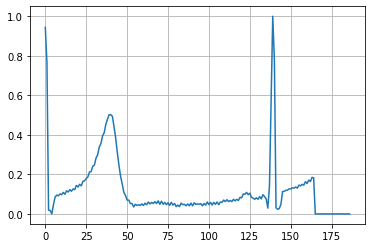

In [ ]:
# The last element contains the labels
labels = raw_data2[:, -1]
labels[labels>0] = 1

print('Class proportion:', np.sum(labels)/labels.shape[0])

# The other data points are the electrocadriogram data
data = raw_data2[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=21)

# Normalize to [0, 1]
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

# plot data
plt.grid()
plt.plot(np.arange(train_data.shape[1]), train_data[0])
plt.show()

### CNN Model

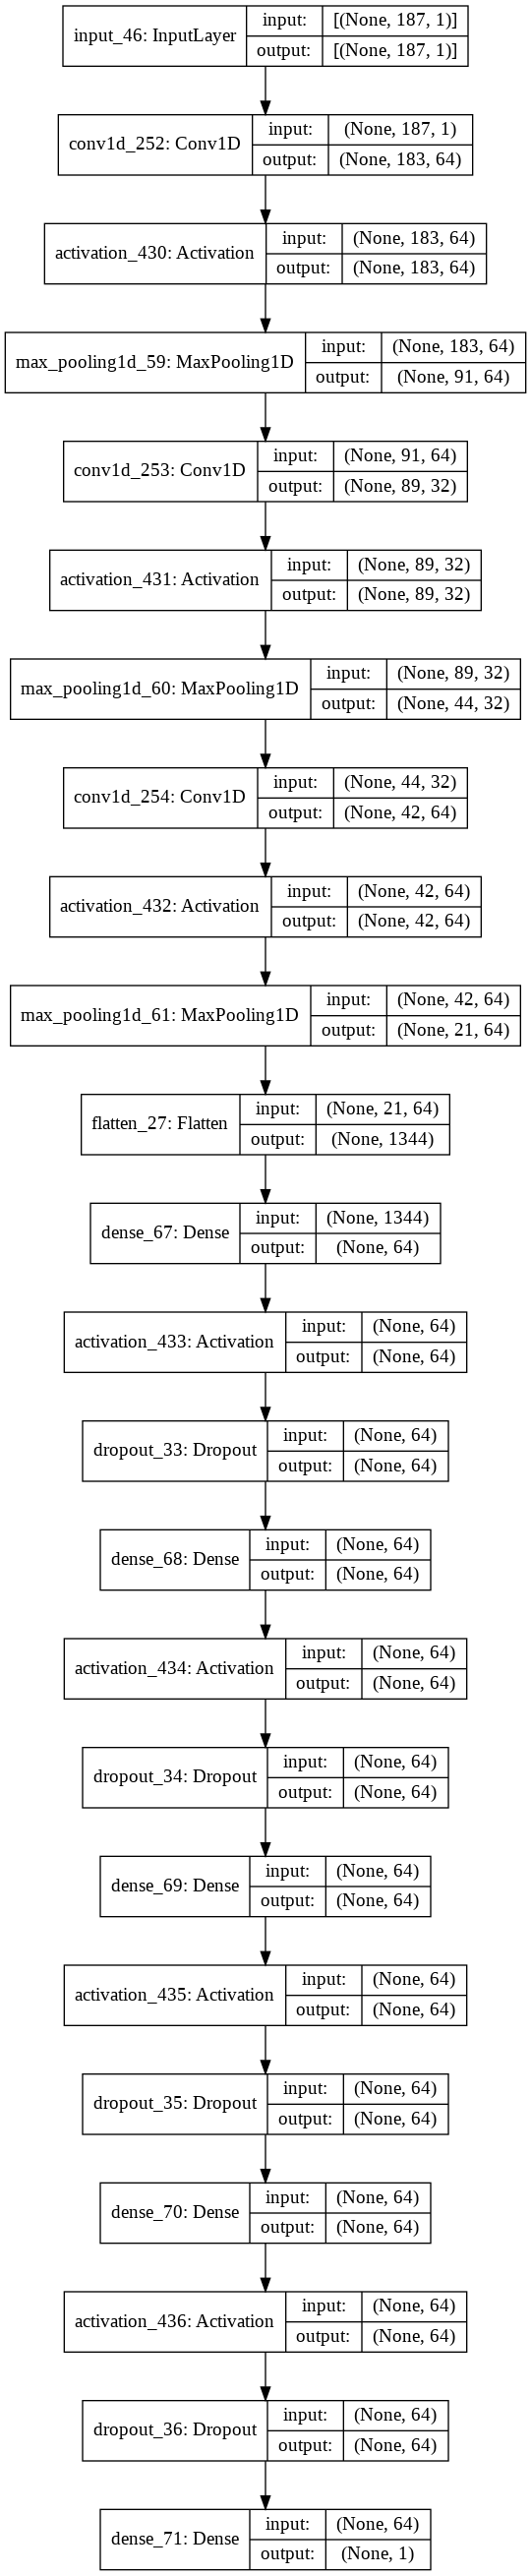

In [ ]:
input = layers.Input(shape=(train_data.shape[1],1)) # input with training data shape

# convulutional layers with max pooling
x = layers.Conv1D(64,5)(input)
x = layers.Activation('relu')(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.Conv1D(32,3)(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.Conv1D(64,3)(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.Flatten()(x)

# dense and dropout layers
x = layers.Dense(64)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)

# final output layer
x = layers.Dense(1,activation='sigmoid')(x)

CNN_model = Model(inputs=input, outputs=x)

## plot
plot_model(CNN_model, show_shapes=True, to_file='CNN_module.png')

In [ ]:
CNN_model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
# Fit the model
checkpoint = ModelCheckpoint("best_model.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = CNN_model.fit(x=train_data,y=train_labels, epochs=2,validation_split=0.2,callbacks=[checkpoint])

Epoch 1/10
2189/2189 [==============================] - 44s 19ms/step - loss: 0.3152 - accuracy: 0.8877 - val_loss: 0.1801 - val_accuracy: 0.9484

Epoch 00001: val_accuracy improved from -inf to 0.94844, saving model to best_model.hdf5
Epoch 2/10
2189/2189 [==============================] - 42s 19ms/step - loss: 0.2161 - accuracy: 0.9410 - val_loss: 0.1637 - val_accuracy: 0.9551

Epoch 00002: val_accuracy improved from 0.94844 to 0.95512, saving model to best_model.hdf5
Epoch 3/10
 834/2189 [==========>...................] - ETA: 24s - loss: 0.2068 - accuracy: 0.9449

KeyboardInterrupt: ignored

### Reprocess data

In [ ]:
## pad so that it can be divided by 4
data = np.pad(data,((0,0),(0,1)))

train_data, test_data2, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=21)

n_steps = 4

train_data = train_data.reshape((train_data.shape[0], n_steps, data.shape[1]//n_steps))
test_data2 = test_data2.reshape((test_data2.shape[0], n_steps, data.shape[1]//n_steps))

# Normalize to [0, 1]
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data2 = (test_data2 - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data2 = tf.cast(test_data2, tf.float32)

### CNN-LSTM Model

In [ ]:
input = layers.Input(shape=(train_data.shape[1],train_data.shape[2],1)) # input layer with training data shape

# dense and dropout layer
x = layers.TimeDistributed(Conv1D(64,5))(input)
x = layers.TimeDistributed(Activation('relu'))(x)
x = layers.TimeDistributed(MaxPooling1D(pool_size=2))(x)
x = layers.TimeDistributed(Conv1D(32,3))(x)
x = layers.TimeDistributed(Activation('relu'))(x)
x = layers.TimeDistributed(MaxPooling1D(pool_size=2))(x)
x = layers.TimeDistributed(Conv1D(64,3))(x)
x = layers.TimeDistributed(Activation('relu'))(x)
x = layers.TimeDistributed(MaxPooling1D(pool_size=2))(x)
x = layers.TimeDistributed(Flatten())(x)
# bidirection lstm layer
x = layers.Bidirectional(layers.LSTM(128,dropout=0.3,recurrent_dropout=0.3))(x)

# dense and dropout layers
x = layers.Dense(64)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)

# decision layer
x = layers.Dense(1,activation='sigmoid')(x)


LSTM_model = Model(inputs=input, outputs=x)

In [ ]:
LSTM_model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
# Fit the model
checkpoint = ModelCheckpoint("best_model.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = LSTM_model.fit(x=train_data,y=train_labels, epochs=3,validation_split=0.2,callbacks=[checkpoint])

Epoch 1/5
2189/2189 [==============================] - 111s 48ms/step - loss: 0.2785 - accuracy: 0.9048 - val_loss: 0.1543 - val_accuracy: 0.9568

Epoch 00001: val_accuracy improved from -inf to 0.95677, saving model to best_model.hdf5
Epoch 2/5
2189/2189 [==============================] - 105s 48ms/step - loss: 0.1524 - accuracy: 0.9535 - val_loss: 0.1242 - val_accuracy: 0.9632

Epoch 00002: val_accuracy improved from 0.95677 to 0.96317, saving model to best_model.hdf5
Epoch 3/5
2189/2189 [==============================] - 117s 53ms/step - loss: 0.1428 - accuracy: 0.9584 - val_loss: 0.1279 - val_accuracy: 0.9617

Epoch 00003: val_accuracy did not improve from 0.96317
Epoch 4/5
 977/2189 [============>.................] - ETA: 55s - loss: 0.1333 - accuracy: 0.9620

KeyboardInterrupt: ignored

### Inception Model

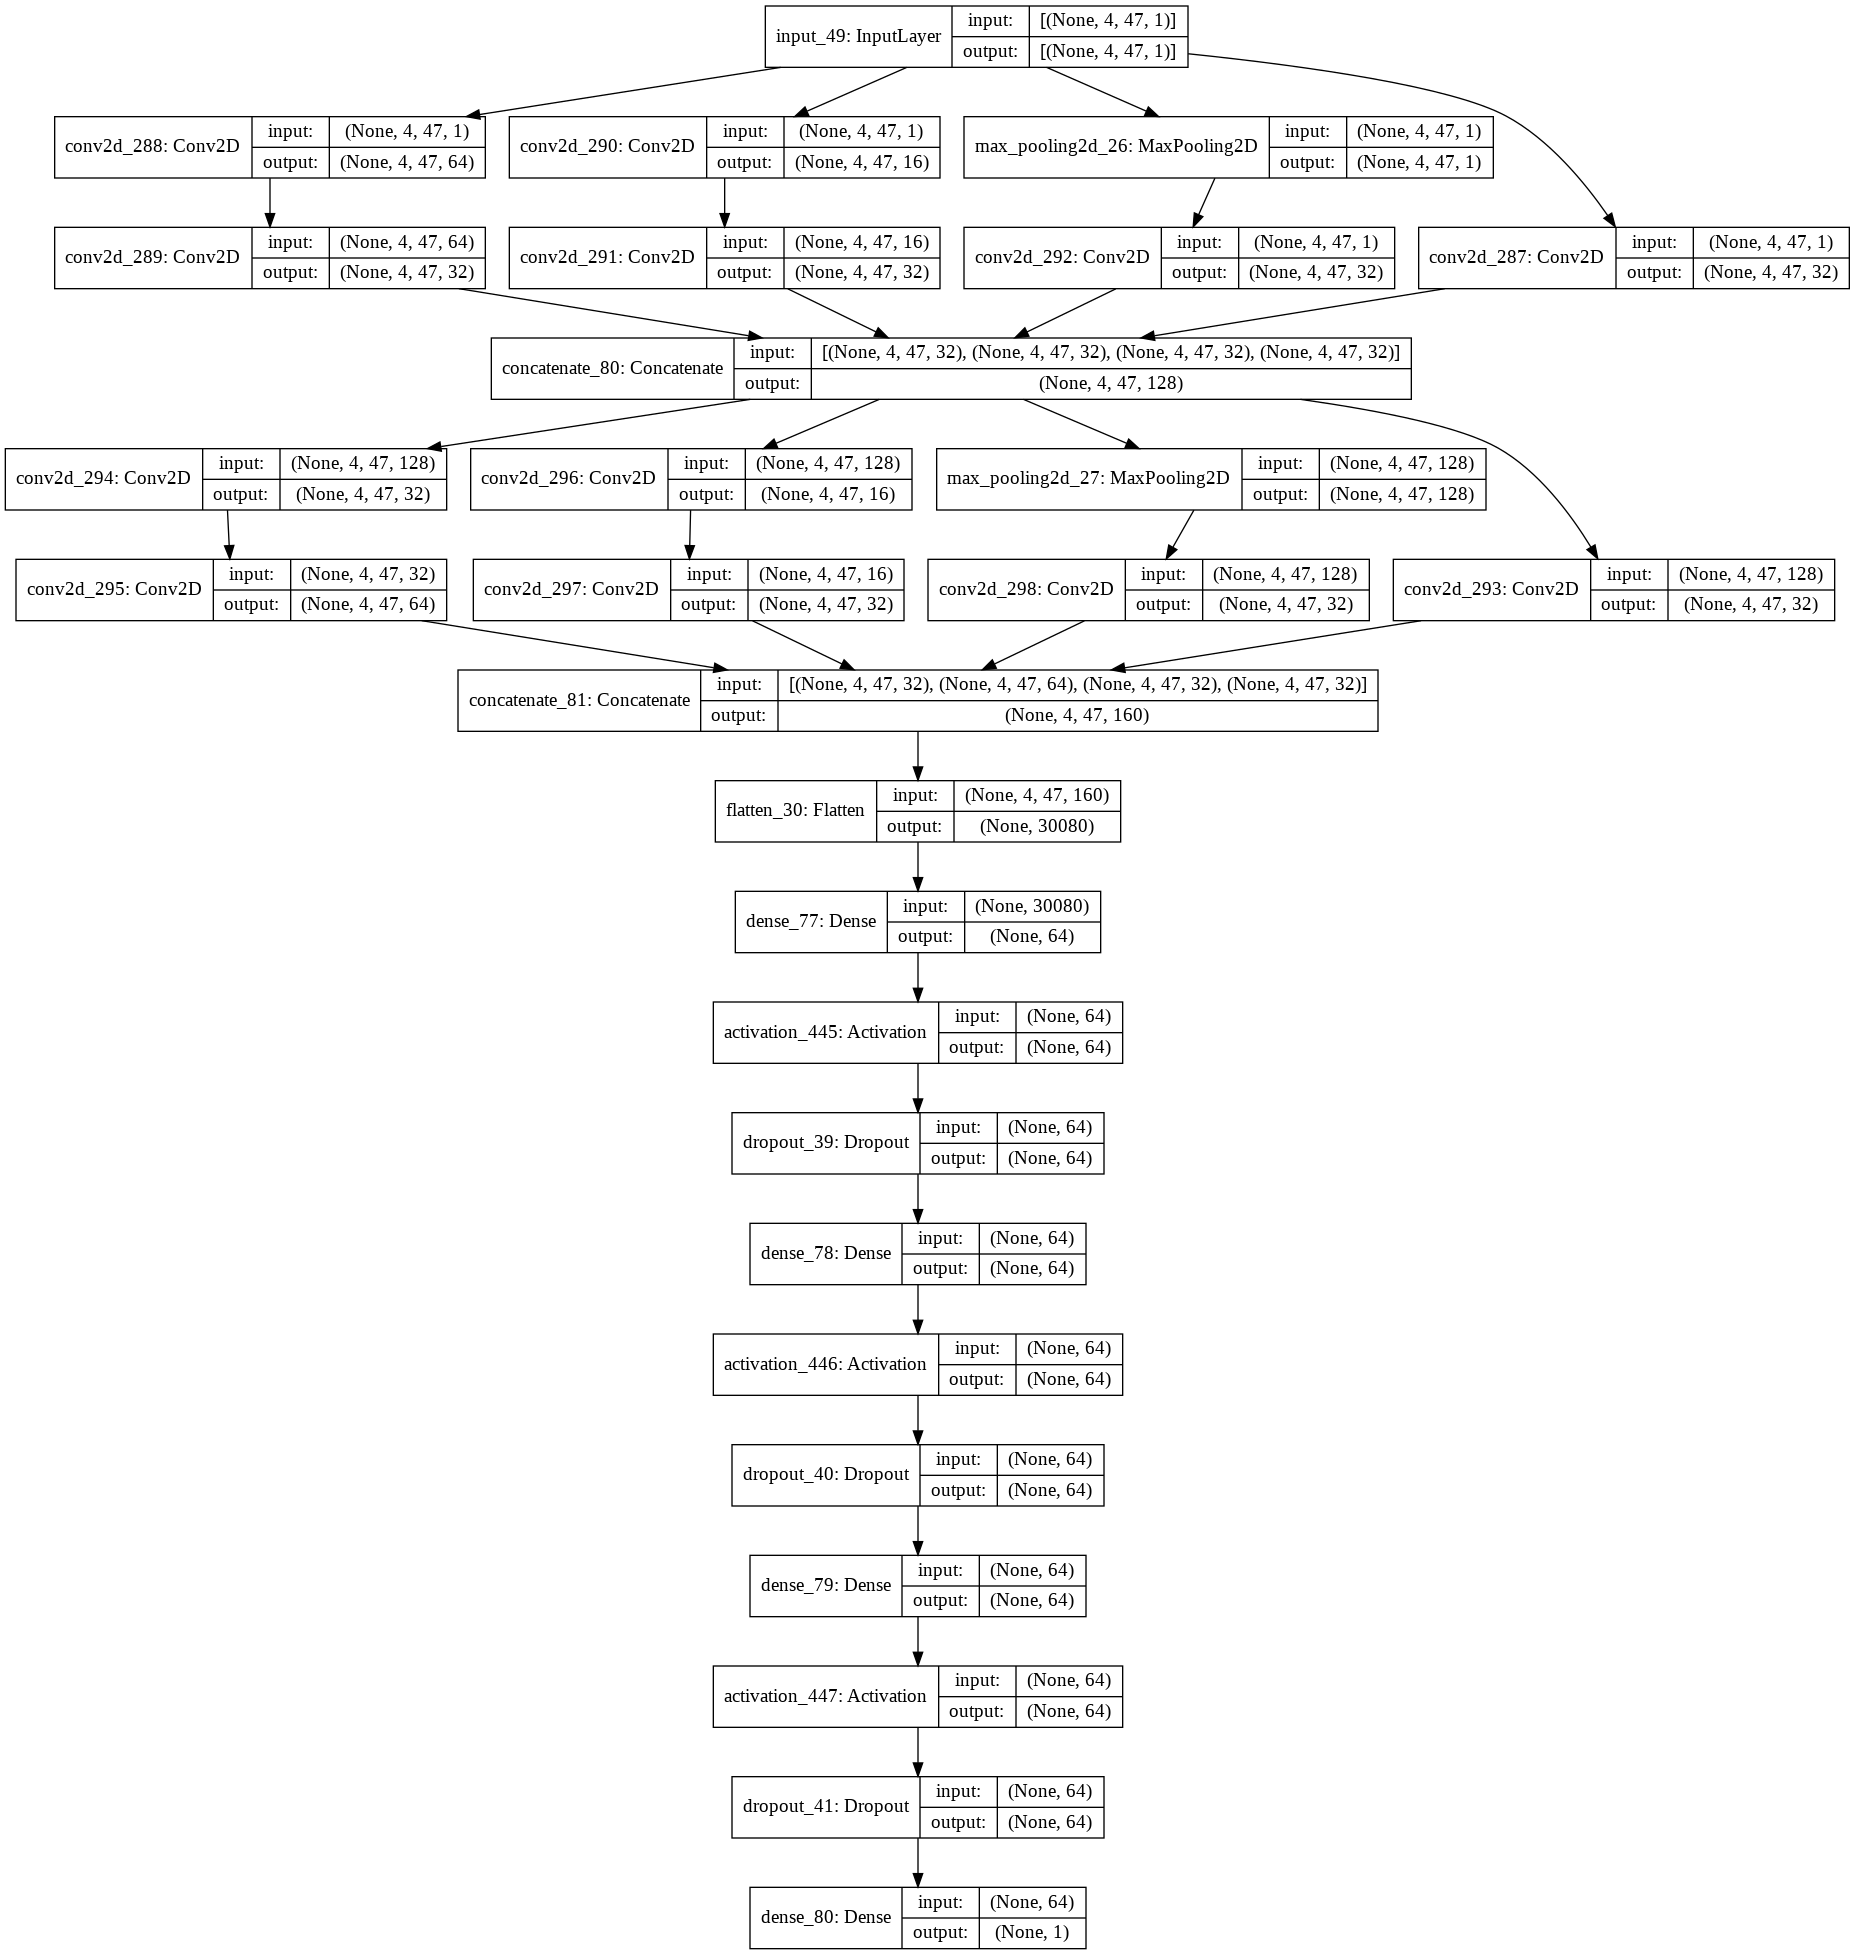

In [ ]:
# define model input
input = layers.Input(shape=(train_data.shape[1], train_data.shape[2],1))
# add inception block 1
x = inception_module(input, 32, 64, 32, 16, 32, 32)
# add inception block 1
x = inception_module(x, 32, 32, 64, 16, 32, 32)
# create model
x = layers.Flatten()(x)
# dense and dropout layers
x = layers.Dense(64)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)

## prediction layer
x = layers.Dense(1,activation='sigmoid')(x)

inception_model = Model(inputs=input, outputs=x)

# plot model architecture
plot_model(inception_model, show_shapes=True, to_file='inception_module.png')

In [ ]:
inception_model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
# Fit the model
checkpoint = ModelCheckpoint("best_model.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = inception_model.fit(x=train_data,y=train_labels, epochs=2,validation_split=0.2,callbacks=[checkpoint])

Epoch 1/3
2189/2189 [==============================] - 354s 161ms/step - loss: 0.2881 - accuracy: 0.8931 - val_loss: 0.1842 - val_accuracy: 0.9479

Epoch 00001: val_accuracy improved from -inf to 0.94792, saving model to best_model.hdf5
Epoch 2/3
2189/2189 [==============================] - 352s 161ms/step - loss: 0.1825 - accuracy: 0.9494 - val_loss: 0.1564 - val_accuracy: 0.9454

Epoch 00002: val_accuracy did not improve from 0.94792
Epoch 3/3
 129/2189 [>.............................] - ETA: 5:17 - loss: 0.1635 - accuracy: 0.9509

KeyboardInterrupt: ignored

### Evaluation

For CNN model:
Accuracy: 0.9526724531749657
AUC-ROC: 0.9656184230698731


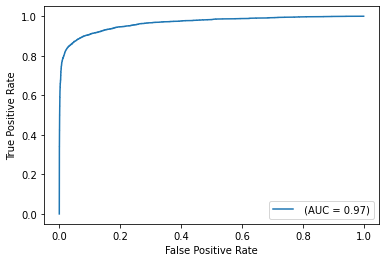

For CNN-LSTM model:
Accuracy: 0.964824120603015
AUC-ROC: 0.9792538408661722


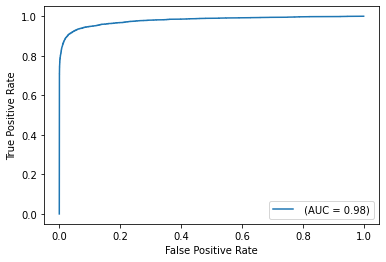

For Inception model:
Accuracy: 0.9487894015532207
AUC-ROC: 0.9590429894334409


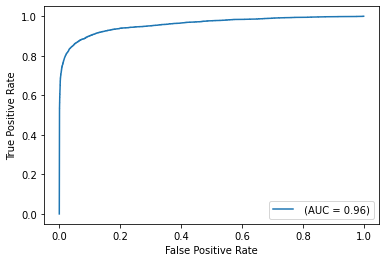

In [ ]:
models = [CNN_model,LSTM_model,inception_model]
modelnames = ['CNN','CNN-LSTM','Inception']

for i, model in enumerate(models):
  print('For', modelnames[i], 'model:')
  ## predict
  if i == 0:
    prediction = model.predict(test_data)
  else:
    prediction = model.predict(test_data2)
  fpr, tpr, _ = roc_curve(test_labels, prediction)
  aucroc = auc(fpr, tpr)
  accuracy = accuracy_score(test_labels,np.round_(prediction))
  print('Accuracy:', accuracy)
  print('AUC-ROC:', aucroc)
  roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr,roc_auc=aucroc,estimator_name = '')
  roc_display.plot()
  plt.show()


## For ptbdb dataset

Class proportion: 0.7219626168224299


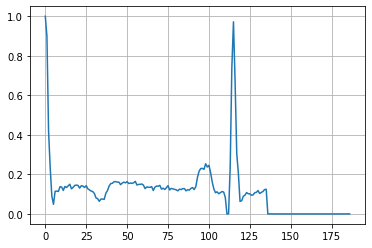

In [ ]:
# The last element contains the labels
labels = raw_data3[:, -1]

print('Class proportion:', np.sum(labels)/labels.shape[0])

# The other data points are the electrocadriogram data
data = raw_data3[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=21)

# Normalize to [0, 1]
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

# plot data
plt.grid()
plt.plot(np.arange(train_data.shape[1]), train_data[0])
plt.show()


### CNN model

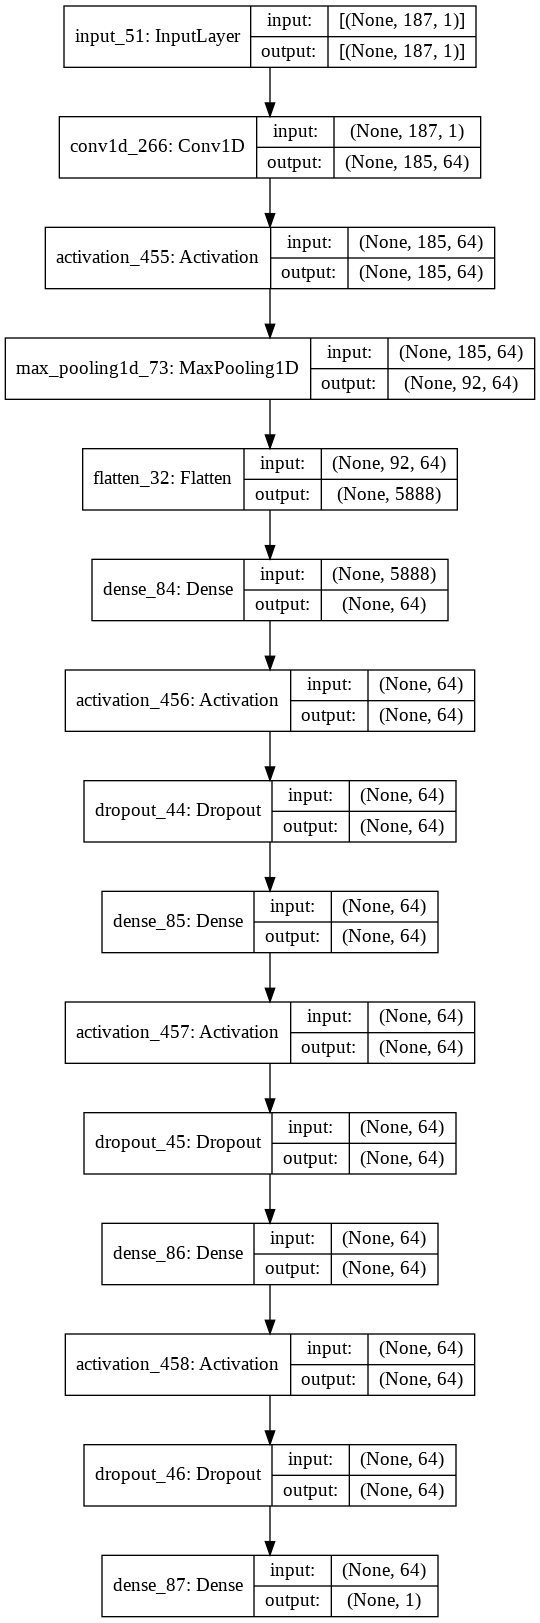

In [ ]:
input = layers.Input(shape=(train_data.shape[1],1)) # input with training data shape

# convulutional layers with max pooling
x = layers.Conv1D(64,5)(input)
x = layers.Activation('relu')(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.Conv1D(32,3)(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.Conv1D(64,3)(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.Flatten()(x)

# dense and dropout layers
x = layers.Dense(64)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)

# final output layer
x = layers.Dense(1,activation='sigmoid')(x)

CNN_model = Model(inputs=input, outputs=x)

## plot
plot_model(CNN_model, show_shapes=True, to_file='CNN_module.png')

In [ ]:
CNN_model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
# Fit the model
checkpoint = ModelCheckpoint("best_model.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = CNN_model.fit(x=train_data,y=train_labels, epochs=10,validation_split=0.2,callbacks=[checkpoint])

Epoch 1/10
291/291 [==============================] - 5s 13ms/step - loss: 0.5226 - accuracy: 0.7261 - val_loss: 0.3531 - val_accuracy: 0.8467

Epoch 00001: val_accuracy improved from -inf to 0.84672, saving model to best_model.hdf5
Epoch 2/10
291/291 [==============================] - 4s 12ms/step - loss: 0.3755 - accuracy: 0.8364 - val_loss: 0.2673 - val_accuracy: 0.9025

Epoch 00002: val_accuracy improved from 0.84672 to 0.90253, saving model to best_model.hdf5
Epoch 3/10
291/291 [==============================] - 4s 13ms/step - loss: 0.3319 - accuracy: 0.8590 - val_loss: 0.2609 - val_accuracy: 0.8879

Epoch 00003: val_accuracy did not improve from 0.90253
Epoch 4/10
291/291 [==============================] - 4s 12ms/step - loss: 0.3032 - accuracy: 0.8784 - val_loss: 0.2244 - val_accuracy: 0.8987

Epoch 00004: val_accuracy did not improve from 0.90253
Epoch 5/10
291/291 [==============================] - 4s 12ms/step - loss: 0.2589 - accuracy: 0.9001 - val_loss: 0.1895 - val_accurac

### Reprocess data

In [ ]:
## pad so that it can be divided by 4
data = np.pad(data,((0,0),(0,1)))

train_data, test_data2, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=21)

n_steps = 4

train_data = train_data.reshape((train_data.shape[0], n_steps, data.shape[1]//n_steps))
test_data2 = test_data2.reshape((test_data2.shape[0], n_steps, data.shape[1]//n_steps))

# Normalize to [0, 1]
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data2 = (test_data2 - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data2 = tf.cast(test_data2, tf.float32)

### CNN-LSTM model

In [ ]:
input = layers.Input(shape=(train_data.shape[1],train_data.shape[2],1)) # input layer with training data shape

# dense and dropout layer
x = layers.TimeDistributed(Conv1D(64,5))(input)
x = layers.TimeDistributed(Activation('relu'))(x)
x = layers.TimeDistributed(MaxPooling1D(pool_size=2))(x)
x = layers.TimeDistributed(Conv1D(32,3))(x)
x = layers.TimeDistributed(Activation('relu'))(x)
x = layers.TimeDistributed(MaxPooling1D(pool_size=2))(x)
x = layers.TimeDistributed(Conv1D(64,3))(x)
x = layers.TimeDistributed(Activation('relu'))(x)
x = layers.TimeDistributed(MaxPooling1D(pool_size=2))(x)
x = layers.TimeDistributed(Flatten())(x)
# bidirection lstm layer
x = layers.Bidirectional(layers.LSTM(128,dropout=0.3,recurrent_dropout=0.3))(x)
x = layers.Dense(64)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)


# decision layer
x = layers.Dense(1,activation='sigmoid')(x)

LSTM_model = Model(inputs=input, outputs=x)


In [ ]:
LSTM_model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
# Fit the model
checkpoint = ModelCheckpoint("best_model.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = LSTM_model.fit(x=train_data,y=train_labels, epochs=10,validation_split=0.2,callbacks=[checkpoint])

Epoch 1/5
291/291 [==============================] - 18s 46ms/step - loss: 0.3114 - accuracy: 0.8757 - val_loss: 0.2239 - val_accuracy: 0.8952

Epoch 00001: val_accuracy improved from -inf to 0.89523, saving model to best_model.hdf5
Epoch 2/5
291/291 [==============================] - 13s 44ms/step - loss: 0.2891 - accuracy: 0.8886 - val_loss: 0.1749 - val_accuracy: 0.9343

Epoch 00002: val_accuracy improved from 0.89523 to 0.93431, saving model to best_model.hdf5
Epoch 3/5
291/291 [==============================] - 13s 44ms/step - loss: 0.2372 - accuracy: 0.9041 - val_loss: 0.1674 - val_accuracy: 0.9476

Epoch 00003: val_accuracy improved from 0.93431 to 0.94762, saving model to best_model.hdf5
Epoch 4/5
291/291 [==============================] - 13s 44ms/step - loss: 0.2315 - accuracy: 0.9095 - val_loss: 0.1579 - val_accuracy: 0.9386

Epoch 00004: val_accuracy did not improve from 0.94762
Epoch 5/5
291/291 [==============================] - 13s 44ms/step - loss: 0.2192 - accuracy: 0.

### Inception Model

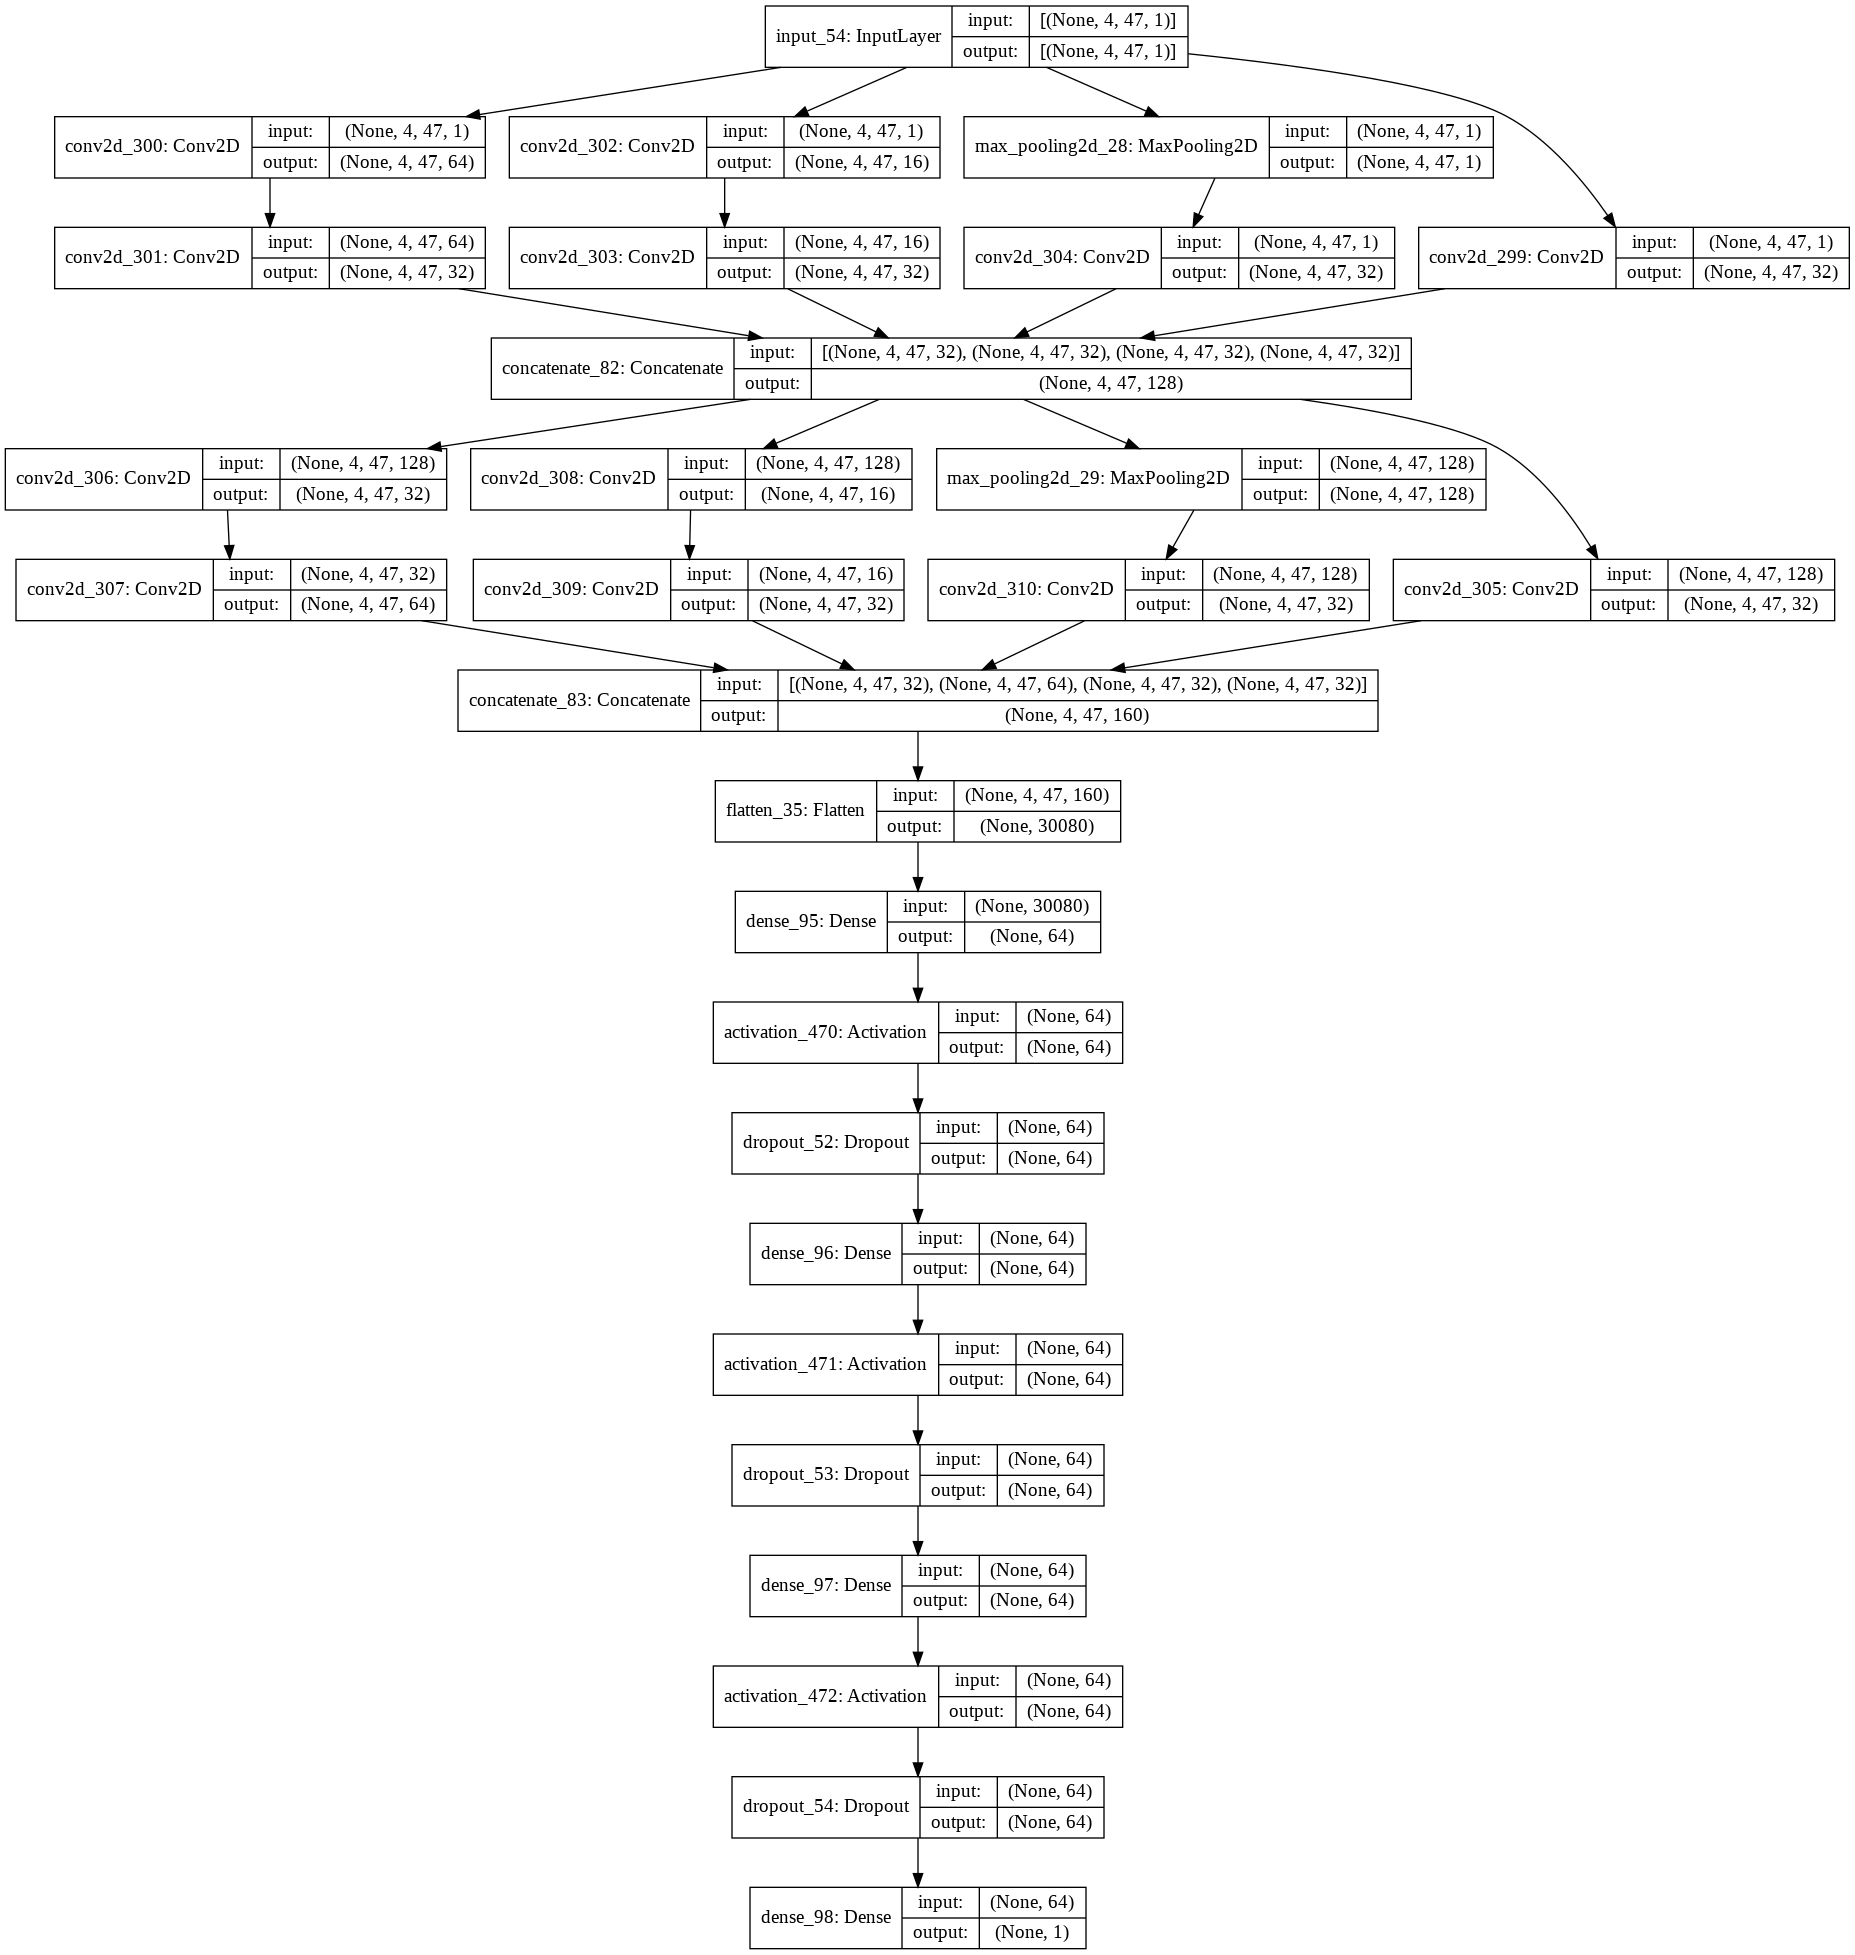

In [ ]:
# define model input
input = layers.Input(shape=(train_data.shape[1], train_data.shape[2],1))
# add inception block 1
x = inception_module(input, 32, 64, 32, 16, 32, 32)
# add inception block 1
x = inception_module(x, 32, 32, 64, 16, 32, 32)
# create model
x = layers.Flatten()(x)
# dense and dropout layers
x = layers.Dense(64)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)

## prediction layer
x = layers.Dense(1,activation='sigmoid')(x)

inception_model = Model(inputs=input, outputs=x)

# plot model architecture
plot_model(inception_model, show_shapes=True, to_file='inception_module.png')

In [ ]:
inception_model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
# Fit the model
checkpoint = ModelCheckpoint("best_model.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = inception_model.fit(x=train_data,y=train_labels, epochs=8,validation_split=0.2,callbacks=[checkpoint])

Epoch 1/5
291/291 [==============================] - 53s 175ms/step - loss: 0.2695 - accuracy: 0.8985 - val_loss: 0.1811 - val_accuracy: 0.9309

Epoch 00001: val_accuracy improved from -inf to 0.93087, saving model to best_model.hdf5
Epoch 2/5
291/291 [==============================] - 51s 174ms/step - loss: 0.2262 - accuracy: 0.9207 - val_loss: 0.1537 - val_accuracy: 0.9433

Epoch 00002: val_accuracy improved from 0.93087 to 0.94332, saving model to best_model.hdf5
Epoch 3/5
291/291 [==============================] - 50s 171ms/step - loss: 0.2124 - accuracy: 0.9238 - val_loss: 0.1710 - val_accuracy: 0.9317

Epoch 00003: val_accuracy did not improve from 0.94332
Epoch 4/5
 84/291 [=======>......................] - ETA: 34s - loss: 0.1712 - accuracy: 0.9447

KeyboardInterrupt: ignored

### Evaluation

For CNN model:
Accuracy: 0.9367914805908623
AUC-ROC: 0.9762116517976898


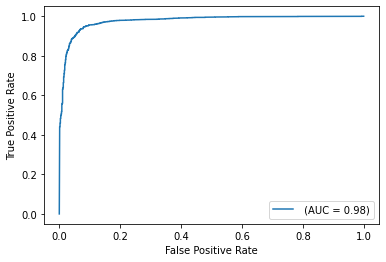

For CNN-LSTM model:
Accuracy: 0.9464101683270354
AUC-ROC: 0.9856761613977644


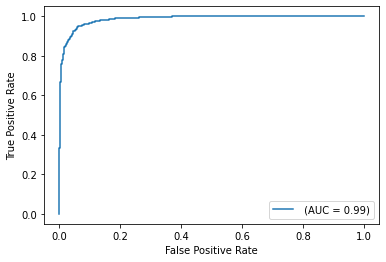

For Inception model:
Accuracy: 0.919271727928547
AUC-ROC: 0.9769001262970778


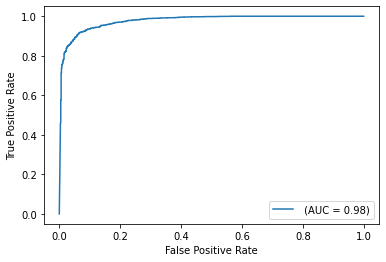

In [ ]:
models = [CNN_model,LSTM_model,inception_model]
modelnames = ['CNN','CNN-LSTM','Inception']

for i, model in enumerate(models):
  print('For', modelnames[i], 'model:')
  ## predict
  if i == 0:
    prediction = model.predict(test_data)
  else:
    prediction = model.predict(test_data2)
  fpr, tpr, _ = roc_curve(test_labels, prediction)
  aucroc = auc(fpr, tpr)
  accuracy = accuracy_score(test_labels,np.round_(prediction))
  print('Accuracy:', accuracy)
  print('AUC-ROC:', aucroc)
  roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr,roc_auc=aucroc,estimator_name = '')
  roc_display.plot()
  plt.show()


## For combined datasets

Class proportion: 0.25025582188594997


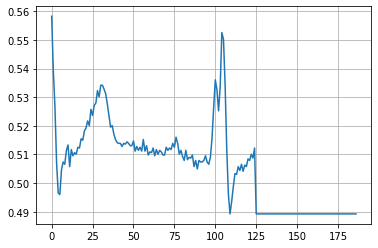

In [ ]:
# The last element contains the labels
labels = np.concatenate([raw_data[:, -1],raw_data2[:, -1],raw_data3[:, -1]])
labels[labels>0] = 1
print('Class proportion:', np.sum(labels)/labels.shape[0])

# The other data points are the electrocadriogram data
data = np.pad(raw_data[:, 0:-1],((0,0),(0,187-raw_data[:, 0:-1].shape[1])))
data = np.vstack((data,raw_data2[:, 0:-1]))
data = np.vstack((data,raw_data3[:, 0:-1]))

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=21)

# Normalize to [0, 1]
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

# plot data
plt.grid()
plt.plot(np.arange(187), train_data[0])
plt.show()

### CNN Model

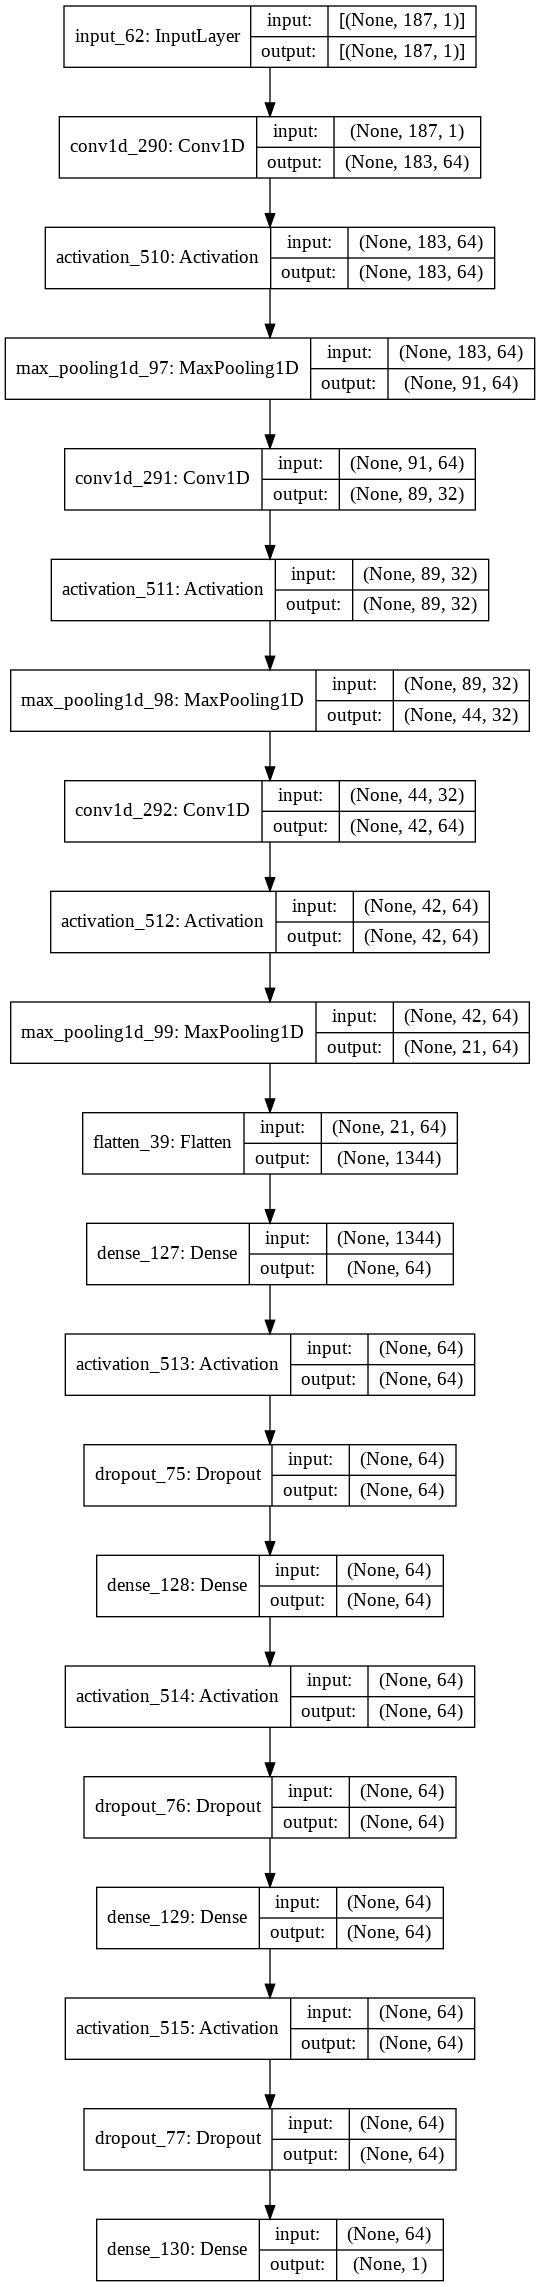

In [ ]:
input = layers.Input(shape=(train_data.shape[1],1)) # input with training data shape

# convulutional layers with max pooling
x = layers.Conv1D(64,5)(input)
x = layers.Activation('relu')(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.Conv1D(32,3)(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.Conv1D(64,3)(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.Flatten()(x)

# dense and dropout layers
x = layers.Dense(64)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)

# final output layer
x = layers.Dense(1,activation='sigmoid')(x)

CNN_model = Model(inputs=input, outputs=x)

## plot
plot_model(CNN_model, show_shapes=True, to_file='CNN_module.png')

In [ ]:
CNN_model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
# Fit the model
checkpoint = ModelCheckpoint("best_model.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = CNN_model.fit(x=train_data,y=train_labels, epochs=3,validation_split=0.2,callbacks=[checkpoint])

Epoch 1/5
2580/2580 [==============================] - 54s 21ms/step - loss: 0.5540 - accuracy: 0.7581 - val_loss: 0.3924 - val_accuracy: 0.8537

Epoch 00001: val_accuracy improved from -inf to 0.85368, saving model to best_model.hdf5
Epoch 2/5
2580/2580 [==============================] - 52s 20ms/step - loss: 0.4089 - accuracy: 0.8455 - val_loss: 0.3616 - val_accuracy: 0.8611

Epoch 00002: val_accuracy improved from 0.85368 to 0.86109, saving model to best_model.hdf5
Epoch 3/5
1950/2580 [=====================>........] - ETA: 11s - loss: 0.3950 - accuracy: 0.8512

KeyboardInterrupt: ignored

### Reprocess

In [ ]:
## pad so that it can be divided by 4
data = np.pad(data,((0,0),(0,1)))

train_data, test_data2, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=21)

n_steps = 4

train_data = train_data.reshape((train_data.shape[0], n_steps, data.shape[1]//n_steps))
test_data2 = test_data2.reshape((test_data2.shape[0], n_steps, data.shape[1]//n_steps))

# Normalize to [0, 1]
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data2 = (test_data2 - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data2 = tf.cast(test_data2, tf.float32)

### CNN-LSTM model

In [ ]:
input = layers.Input(shape=(train_data.shape[1],train_data.shape[2],1)) # input layer with training data shape

# dense and dropout layer
x = layers.TimeDistributed(Conv1D(64,5))(input)
x = layers.TimeDistributed(Activation('relu'))(x)
x = layers.TimeDistributed(MaxPooling1D(pool_size=2))(x)
x = layers.TimeDistributed(Conv1D(32,3))(x)
x = layers.TimeDistributed(Activation('relu'))(x)
x = layers.TimeDistributed(MaxPooling1D(pool_size=2))(x)
x = layers.TimeDistributed(Conv1D(64,3))(x)
x = layers.TimeDistributed(Activation('relu'))(x)
x = layers.TimeDistributed(MaxPooling1D(pool_size=2))(x)
x = layers.TimeDistributed(Flatten())(x)
# bidirection lstm layer
x = layers.Bidirectional(layers.LSTM(128,dropout=0.3,recurrent_dropout=0.3))(x)

x = layers.Dense(64)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)

# decision layer
x = layers.Dense(1,activation='sigmoid')(x)

LSTM_model = Model(inputs=input, outputs=x)

In [ ]:
LSTM_model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
# Fit the model
checkpoint = ModelCheckpoint("best_model.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = LSTM_model.fit(x=train_data,y=train_labels, epochs=3,validation_split=0.2,callbacks=[checkpoint])

Epoch 1/5
2580/2580 [==============================] - 130s 48ms/step - loss: 0.5715 - accuracy: 0.7496 - val_loss: 0.4664 - val_accuracy: 0.8093

Epoch 00001: val_accuracy improved from -inf to 0.80925, saving model to best_model.hdf5
Epoch 2/5
2580/2580 [==============================] - 123s 48ms/step - loss: 0.4664 - accuracy: 0.8119 - val_loss: 0.4057 - val_accuracy: 0.8503

Epoch 00002: val_accuracy improved from 0.80925 to 0.85029, saving model to best_model.hdf5
Epoch 3/5
2580/2580 [==============================] - 124s 48ms/step - loss: 0.4316 - accuracy: 0.8328 - val_loss: 0.4006 - val_accuracy: 0.8463

Epoch 00003: val_accuracy did not improve from 0.85029
Epoch 4/5
1604/2580 [=================>............] - ETA: 44s - loss: 0.4230 - accuracy: 0.8390

KeyboardInterrupt: ignored

### Inception Model

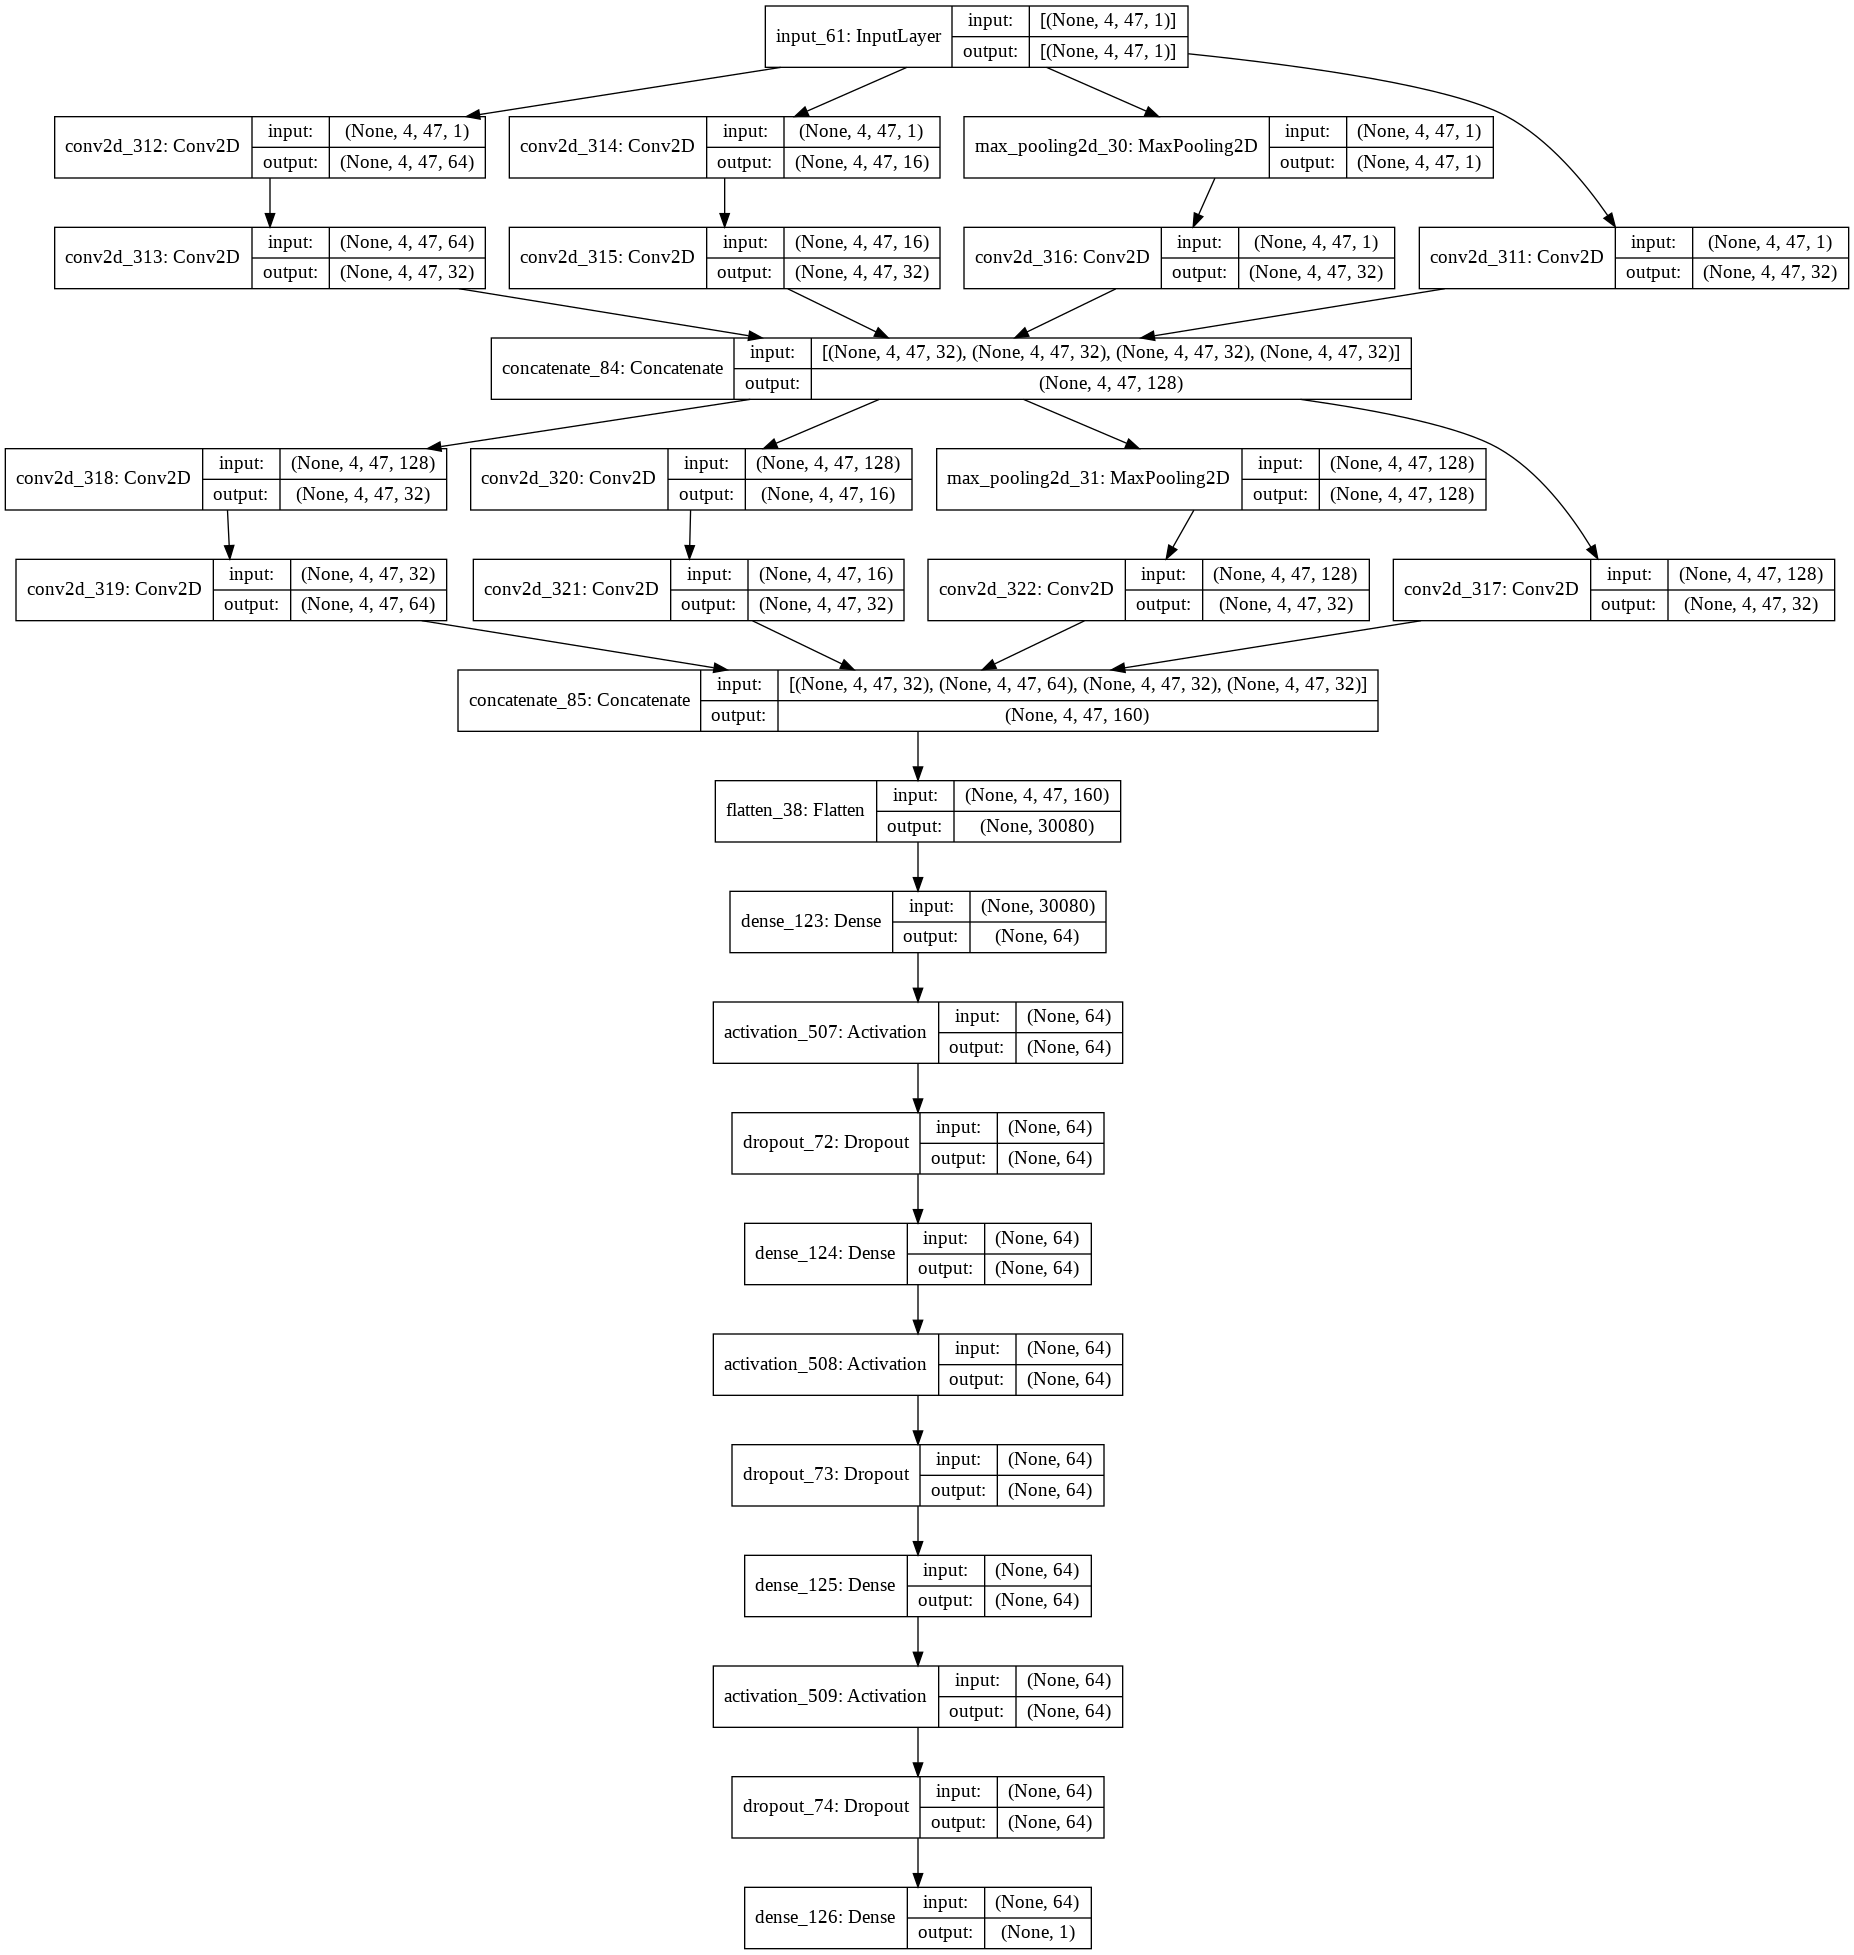

In [ ]:
# define model input
input = layers.Input(shape=(train_data.shape[1], train_data.shape[2],1))
# add inception block 1
x = inception_module(input, 32, 64, 32, 16, 32, 32)
# add inception block 1
x = inception_module(x, 32, 32, 64, 16, 32, 32)
# create model
x = layers.Flatten()(x)
# dense and dropout layers
x = layers.Dense(64)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)

## prediction layer
x = layers.Dense(1,activation='sigmoid')(x)

inception_model = Model(inputs=input, outputs=x)

# plot model architecture
plot_model(inception_model, show_shapes=True, to_file='inception_module.png')

In [ ]:
inception_model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
# Fit the model
checkpoint = ModelCheckpoint("best_model.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = inception_model.fit(x=train_data,y=train_labels, epochs=3,validation_split=0.2,callbacks=[checkpoint])

Epoch 1/3
2580/2580 [==============================] - 420s 162ms/step - loss: 0.5628 - accuracy: 0.7494 - val_loss: 0.4424 - val_accuracy: 0.8375

Epoch 00001: val_accuracy improved from -inf to 0.83745, saving model to best_model.hdf5
Epoch 2/3
2580/2580 [==============================] - 415s 161ms/step - loss: 0.4604 - accuracy: 0.8319 - val_loss: 0.3993 - val_accuracy: 0.8696

Epoch 00002: val_accuracy improved from 0.83745 to 0.86957, saving model to best_model.hdf5
Epoch 3/3
2580/2580 [==============================] - 412s 160ms/step - loss: 0.4171 - accuracy: 0.8534 - val_loss: 0.3481 - val_accuracy: 0.8815

Epoch 00003: val_accuracy improved from 0.86957 to 0.88149, saving model to best_model.hdf5


### Evaluation

For CNN model:
Accuracy: 0.8589147286821706
AUC-ROC: 0.8534479786108501


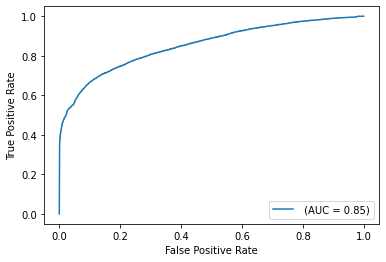

For CNN-LSTM model:
Accuracy: 0.8576744186046512
AUC-ROC: 0.8212088554102145


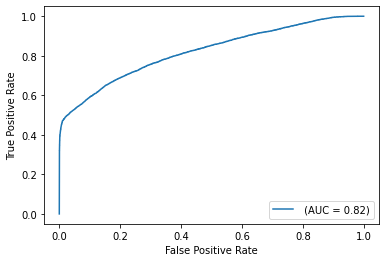

For Inception model:
Accuracy: 0.8812403100775194
AUC-ROC: 0.9057100158852133


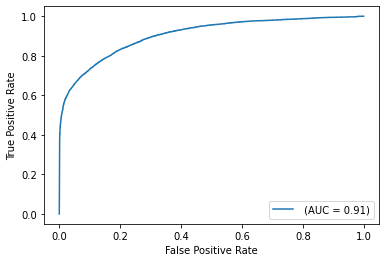

In [ ]:
models = [CNN_model,LSTM_model,inception_model]
modelnames = ['CNN','CNN-LSTM','Inception']

for i, model in enumerate(models):
  print('For', modelnames[i], 'model:')
  ## predict
  if i == 0:
    prediction = model.predict(test_data)
  else:
    prediction = model.predict(test_data2)
  fpr, tpr, _ = roc_curve(test_labels, prediction)
  aucroc = auc(fpr, tpr)
  accuracy = accuracy_score(test_labels,np.round_(prediction))
  print('Accuracy:', accuracy)
  print('AUC-ROC:', aucroc)
  roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr,roc_auc=aucroc,estimator_name = '')
  roc_display.plot()
  plt.show()
